# 1
# Dataset

[Available Here](https://www.kaggle.com/cdc/behavioral-risk-factor-surveillance-system)

(in **data** folder)

The following data set is from the Centers for Disease Control and Prevention (CDC) and includes socioeconomic and lifestyle indicators for hundreds of thousands of individuals. The objective is to predict the overall health of an individual: either 0 for poor health or 1 for good health. We'll limit the data to 100,000 individuals to speed up training. 

The problem is imbalanced (far more of one label than another) so for assessing performance, we'll use recall, precision, receiver operating characteristic area under the curve (ROC AUC), and also plot the ROC curve. **Accuracy is not a useful metric when dealing with an imbalanced problem.**

In [1]:
import numpy as np
import pandas as pd 

# Set random seed to ensure reproducible runs
RSEED = 50

## Data Cleaning 

We'll read the data in and do a little cleaning. 

In [10]:
df = pd.read_csv('data/dtrs/2015_sample.csv').sample(75000, random_state = RSEED)
df.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENUM,...,_PAREC1,_PASTAE1,_LMTACT1,_LMTWRK1,_LMTSCL1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
383119,49.0,4.0,b'05192015',b'05',b'19',b'2015',1100.0,2.015009e+09,2.015009e+09,NaN,...,4.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
55536,9.0,9.0,b'09232015',b'09',b'23',b'2015',1100.0,2.015005e+09,2.015005e+09,1.0,...,2.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
267093,34.0,10.0,b'11052015',b'11',b'05',b'2015',1100.0,2.015011e+09,2.015011e+09,NaN,...,4.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
319092,41.0,4.0,b'04062015',b'04',b'06',b'2015',1100.0,2.015002e+09,2.015002e+09,1.0,...,2.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0,1.0,2.0
420978,54.0,5.0,b'05112015',b'05',b'11',b'2015',1100.0,2.015004e+09,2.015004e+09,NaN,...,1.0,1.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0


In [11]:
df = df.select_dtypes('number')
len(df.columns)

323

### Label Distribution

In [12]:
df['_RFHLTH'] = df['_RFHLTH'].replace({2: 0})
df = df.loc[df['_RFHLTH'].isin([0, 1])].copy()
df = df.rename(columns = {'_RFHLTH': 'label'})
df['label'].value_counts()

1.0    81140
0.0    18579
Name: label, dtype: int64

The label imbalanced means that accuracy is not the best metric. 

We won't do any data exploration in this notebook, but in general, exploring the data is a best practice. This can help you for feature engineering (which we also won't do here) or by identifying and correcting anomalies / mistakes in the data.

Below, we drop a number of columns that we should not use for modeling (they are different versions of the labels).

In [13]:
# Remove columns with missing values
df = df.drop(columns = ['POORHLTH', 'PHYSHLTH', 'GENHLTH', 'PAINACT2', 
                        'QLMENTL2', 'QLSTRES2', 'QLHLTH2', 'HLTHPLN1', 'MENTHLTH'])

## Split Data into Training and Testing Set

To assess our predictions, we'll need to use a training and a testing set. The model learns from the training data and then makes predictions on the testing data. Since we have the correct answers for the testing data, we can tell how well the model is able to generalize to new data. It's important to only use the testing set once, because this is meant to be an estimate of how well the model will perform on new data. 

We'll save 30% of the examples for testing. 

In [14]:
from sklearn.model_selection import train_test_split

# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

#### Imputation of Missing values

We'll fill in the missing values with the mean of the column. It's important to note that we fill in missing values in the test set with the mean of columns in the training data. This is necessary because if we get new data, we'll have to use the training data to fill in any missing values. 

In [7]:
train = train.fillna(train.mean())
test = test.fillna(test.mean())

# Features for feature importances
features = list(train.columns)

In [8]:
train.shape

(69803, 313)

In [9]:
test.shape

(29916, 313)

# 2
## Decision Tree

A simple linear classifier will not be able to draw a boundary that separates the classes. The single decision tree will be able to completely separate the points because it essentially draws many repeated linear boundaries between points. A decision tree is a non-parametric model because the number of parameters grows with the size of the data.

### Single Decision Tree

Here we build and train a single decision tree on the data using Scikit-Learn. The tree will learn how to separate the points, building a flowchart of questions based on the feature values and the labels. At each stage, the decision tree makes splits by maximizing the reduction in **Gini impurity**. 

We'll use the default hyperparameters for the decision tree which means it can grow as deep as necessary in order to completely separate the classes. This will lead to overfitting because the model memorizes the training data, and in practice, we usually want to limit the depth of the tree so it can generalize to testing data.

A decision tree is an intuitive model: it makes decisions much as we might when faced with a problem by constructing a flowchart of questions. For each of the nodes (except the leaf nodes), the five rows represent:

1. Question asked about the data based on a feature: this determines the way we traverse down the tree for a new datapoint.
2. `gini`: the Gini Impurity of the node. The average (weighted by samples) gini impurity decreases with each level of the tree.
3. `samples`: number of training observations in the node
4. `value`: [number of samples in the first class, number of samples in the second class]
5. `class`: the class predicted for all the points in the node if the tree ended at this depth (defaults to 0 for a tie).

First, we'll train the decision tree on the data. Let's leave the depth unlimited and see if we get overfitting! 

In [10]:
from sklearn.tree import DecisionTreeClassifier
# Make a decision tree and train
tree = DecisionTreeClassifier(random_state=RSEED)
# Train tree
tree.fit(train, train_labels)
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

Decision tree has 12327 nodes with maximum depth 55.


## Decision Tree Performance

Given the number of nodes in our decision tree and the maximum depth, we expect it has overfit to the training data. This means it will do much better on the training data than on the testing data.

In [11]:
# Make probability predictions
train_probs = tree.predict_proba(train)[:, 1]
probs = tree.predict_proba(test)[:, 1]

train_predictions = tree.predict(train)
predictions = tree.predict(test)

In [12]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(train_labels, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(test_labels, probs)}')

Train ROC AUC Score: 1.0
Test ROC AUC  Score: 0.6639639045644772


In [13]:
print(f'Baseline ROC AUC: {roc_auc_score(test_labels, [1 for _ in range(len(test_labels))])}')

Baseline ROC AUC: 0.5


Our model does outperform a baseline guess, but we can see it has severely overfit to the training data, acheiving perfect ROC AUC.

## Evaluate the Decision Tree

We'll write a short function that calculates a number of metrics for the baseline (guessing the most common label in the training data), the testing predictions, and the training predictions. The function also plots the ROC curve where a better model is to the left and towards the top. 

In [14]:
import matplotlib.pyplot as plt

In [15]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');


In [16]:
from collections import Counter
print(Counter(probs))
print(Counter(predictions))

Counter({1.0: 23139, 0.0: 6777})
Counter({1.0: 23139, 0.0: 6777})


Recall Baseline: 1.0 Test: 0.83 Train: 1.0
Precision Baseline: 0.81 Test: 0.88 Train: 1.0
Roc Baseline: 0.5 Test: 0.66 Train: 1.0


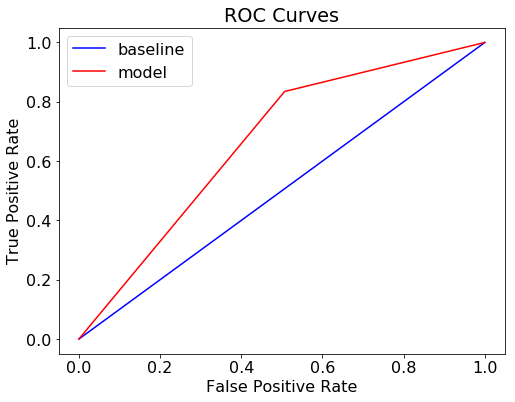

In [17]:
evaluate_model(predictions, probs, train_predictions, train_probs)

There we can see the problem with a single decision tree where the maximum depth is not limited: __severe overfitting to the training data__. 

Another method to inspect the performance of a classification model is by making a confusion matrix.

### Confusion Matrix

In [18]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[ 2750  2824]
 [ 4027 20315]]


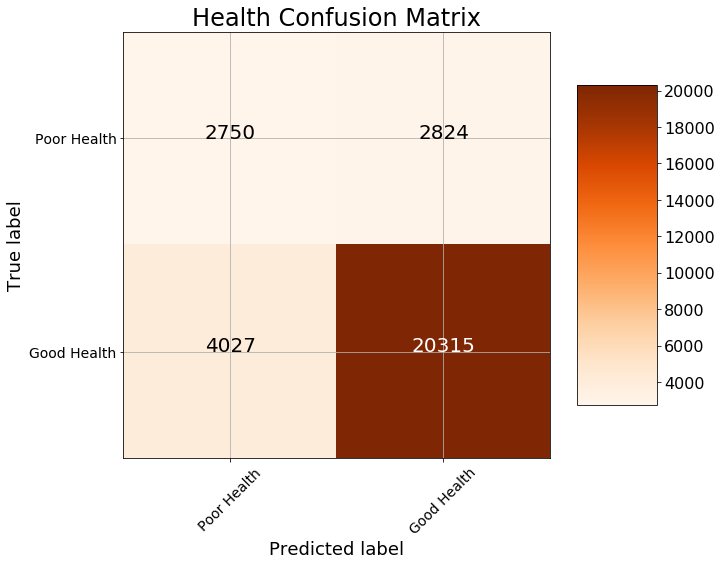

In [19]:
cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix')

This shows the classifications predicted by the model on the test data along with the real labels. We can see that our model has many false negatives (predicted good health but actually poor health) and false positives (predicted poor health but actually good health). 

### Feature Importances

Finally, we can take a look at the features considered most important by the Decision Tree. The values are computed by summing the reduction in Gini Impurity over all of the nodes of the tree in which the feature is used. 

In [20]:
fi = pd.DataFrame({'feature': features,
                   'importance': tree.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head()

,feature,importance
62,DIFFWALK,0.191702
58,QLACTLM2,0.030550
51,EMPLOY1,0.023743
64,DIFFALON,0.018419
245,_BMI5,0.016785


We won't go through the definitions here, but you can look through the [data dictionary](https://www.kaggle.com/cdc/behavioral-risk-factor-surveillance-system#2015_formats.json) to determine the meaning of each feature. 

# 3.1
# Random Forest 

Now we can move on to a more powerful model, the random forest. This takes the idea of a single decision tree, and creates an _ensemble_ model out of hundreds or thousands of trees to reduce the variance. Each tree is trained on a random set of the observations, and for each split of a node, only a subset of the features are used for making a split. When making predictions, the random forest averages the predictions for each of the individual decision trees for each data point in order to arrive at a final classification.

Creating and training a random forest in extremely easy in Scikit-Learn. The cell below is all you need.

In [21]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.5s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

We can see how many nodes there are for each tree on average and the maximum depth of each tree. There were 100 trees in the forest.

In [22]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 13396
Average maximum depth 46


We see that each decision tree in the forest has many nodes and is extremely deep. However, even though each individual decision tree may overfit to a particular subset of the training data, the idea is that the overall random forest should have a reduced variance. 

## Random Forest Results

In [23]:
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished


Recall Baseline: 1.0 Test: 0.96 Train: 1.0
Precision Baseline: 0.81 Test: 0.88 Train: 1.0
Roc Baseline: 0.5 Test: 0.87 Train: 1.0


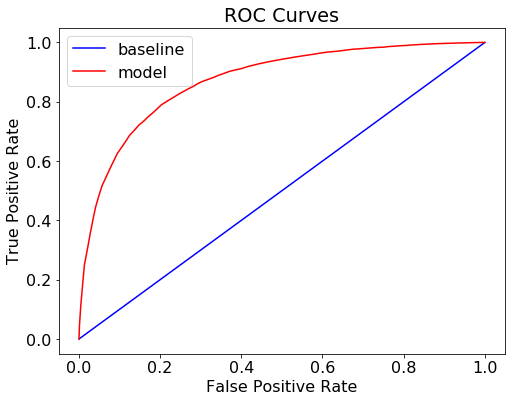

In [24]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

The model still achieves perfect measures on the training data, but this time, the testing scores are much better. If we compare the ROC AUC, we see that the random forest does significantly better than a single decision tree. 

Confusion matrix, without normalization
[[ 2438  3136]
 [ 1043 23299]]


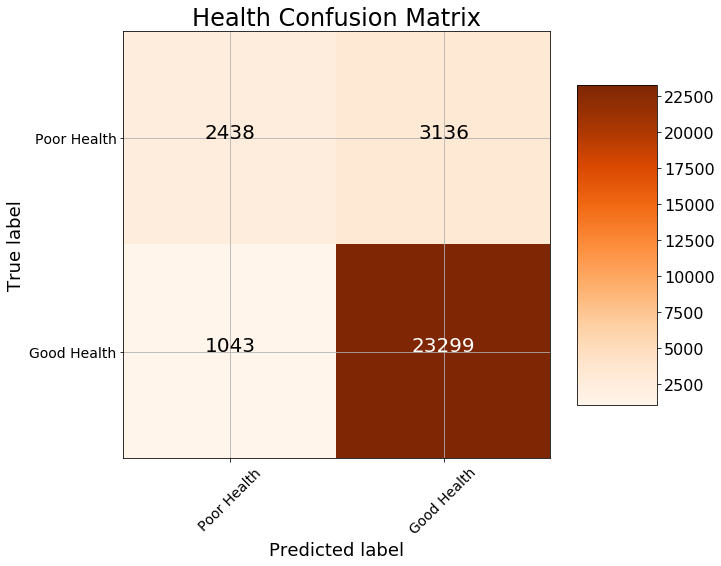

In [25]:
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix')

Compared to the single decision tree, the model has fewer false postives although more false negatives. __Overall, the random forest does significantly better than a single decision tree__. This is what we expected!

In [26]:
fi_model = pd.DataFrame({'feature': features,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(10)

,feature,importance
62,DIFFWALK,0.036200
58,QLACTLM2,0.030694
51,EMPLOY1,0.024156
64,DIFFALON,0.022699
59,USEEQUIP,0.016922
61,DECIDE,0.016271
307,_LMTSCL1,0.013424
53,INCOME2,0.011929
37,CHCCOPD1,0.011506
245,_BMI5,0.011497


Our model does pretty well! Compared to the single decision tree, the random forest is much better able to generalize to new data.

# 3.2
# Random Forest Optimization through Random Search

In order to maximize the performance of the random forest, we can perform a random search for better hyperparameters. This will randomly select combinations of hyperparameters from a grid, evaluate them using cross validation on the training data, and return the values that perform the best. 

In [28]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 5, verbose = 1, random_state=RSEED)

# Fit 
rs.fit(train, train_labels)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [ ]:
rs.best_params_

We can see that the best hyperparameter values are not the defaults. This shows the importance of tuning a model for a specific dataset. Each dataset will have different characteristics, and the model that does best on one dataset will not necessarily do the best across all datasets. 

### Use Best Model

Now we can take the best model (it has already been trained) and evaluate it. Hopefully it does better than the stock Random Forest.

In [ ]:
best_model = rs.best_estimator_

In [ ]:
train_rf_predictions = best_model.predict(train)
train_rf_probs = best_model.predict_proba(train)[:, 1]

rf_predictions = best_model.predict(test)
rf_probs = best_model.predict_proba(test)[:, 1]

In [ ]:
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

The best maximum depth is not unlimited as we see above! This indicates that restricting the maximum depth of the individual decision trees can improve the cross validation performance of the random forest. 

In [ ]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

The optimized model achieves around the same performance as the default model. More random search iterations could improve performance, or it's possible that we are close the limit of what the random forest can achieve for this problem.

This tree is a little simpler than the solitary decision tree model. Random search found that limiting the maximum depth of the trees in the forest delivers better performance than letting them expand as far as needed. 

# 4
## Saving and loading models

The models can be saved as pickle files and can be loaded and used to make predictions. A simple REST API can be built to parse input data and get predictions from the model file.

In [ ]:
import pickle
with open('models/random_search.pkl', 'wb') as f:
    pickle.dump(rs, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('models/random_search.pkl', 'rb') as f:
    model = pickle.load(f)

In [ ]:
rf_predictions = model.predict(test[5:6])
rf_probs = model.predict_proba(test[5:6])[:, 1]

In [ ]:
rf_predictions, rf_probs